In [17]:
import xarray as xr
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import numpy as np
import numpy.ma as ma
import rasterio
from rasterio.plot import show


In [18]:
path = 'D:\\3_DataViz\\2_glaciers\\3_ncdf\\'
ncdf_src = 'GLIDATASET_ALPS.nc'

ds = xr.open_dataset(path + ncdf_src)

In [19]:
ds.values()
# https://towardsdatascience.com/handling-netcdf-files-using-xarray-for-absolute-beginners-111a8ab4463f

ValuesView(<xarray.Dataset>
Dimensions:       (x: 11722, y: 6182)
Coordinates:
  * x             (x) int32 264325 264375 264425 264475 ... 850325 850375 850425
  * y             (y) int32 4963100 4963150 4963200 ... 5272100 5272150 5272200
Data variables:
    mapping       |S1 ...
    vx            (y, x) float32 ...
    vy            (y, x) float32 ...
    stdx          (y, x) float32 ...
    stdy          (y, x) float32 ...
    thickness     (y, x) float32 ...
    errthickness  (y, x) float32 ...
    slope         (y, x) float32 ...
Attributes:
    Conventions:  CF-1.6
    Title:        GLacier Ice dynamics DATASET  for ALPS
    Version:      1.0.0 (August2019)
    Author:       R. Millan, J. Mouginot, A. Rabatel, M. Morlighem
    history:      Created Tue Apr 20 16:57:31 2021
    Notes:        Data were processed at the Institut des Geosciences de l En...
    nx:           11722
    ny:           6182
    Projection:   UTM
    proj4:        +proj=utm +zone=32 +datum=WGS84 +units=m +

In [20]:
# Explore the netcdf

#ds.keys()
ds.attrs
#ds.var()
#ds.thickness.dims
#ds.thickness.coords
#ds.thickness.coords['x']

{'Conventions': 'CF-1.6',
 'Title': 'GLacier Ice dynamics DATASET  for ALPS',
 'Version': '1.0.0 (August2019)',
 'Author': 'R. Millan, J. Mouginot, A. Rabatel, M. Morlighem',
 'history': 'Created Tue Apr 20 16:57:31 2021',
 'Notes': 'Data were processed at the Institut des Geosciences de l Environnement, Grenoble, France',
 'nx': 11722,
 'ny': 6182,
 'Projection': 'UTM',
 'proj4': '+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs'}

<xarray.DataArray 'VX' (y: 17946, x: 10018)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float64 -6.38e+05 -6.378e+05 -6.377e+05 ... 8.644e+05 8.646e+05
  * y        (y) float64 -6.576e+05 -6.578e+05 ... -3.349e+06 -3.349e+06
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
Attributes:
    long_name:      Ice velocity in x direction
    standard_name:  land_ice_x_velocity
    units:          meter/year
    grid_mapping:   coord_system

In [22]:
# Extract data as a numpy array
arr = np.sqrt(np.square(ds.vx.data)+np.square(ds.vy.data))
# Create a masked array for making calculations without nodata values
arr = np.nan_to_num(arr,posinf=-9999)
arr_ma = np.ma.masked_where(arr == -9999, arr, copy=True)

In [24]:
arr_ma

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

In [9]:
# Scale the velocities by the log of the data.
d = np.log(np.clip(arr, 1, 1000))
# Rescaling (min-max normalization) - 255 for RGB ??
scaled_ds = (255*(d - np.amin(d))/np.ptp(d)).astype(np.uint8)
ma.set_fill_value(scaled_ds, -999999)

In [10]:
scaled_ds

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
print(d.shape)
print(np.ptp(d))
print(np.amin(d))


(17946, 10018)
6.9077554
0.0


In [12]:
# Construct a colormap with log scale 
# designed by Terry Haran, NSIDC, April 2018. 
# Construct an RGB table using a log scale between 1 and 500 m/year.
vel = np.exp(np.linspace(np.log(1), np.log(500), num=256)) 
hue = np.arange(256) / 255.0 
sat = np.clip(1. / 3 + vel / 187.5, 0, 1) 
value = np.zeros(256) + 0.75 
hsv = np.stack((hue, sat, value), axis=1) 
rgb = colors.hsv_to_rgb(hsv) 
# Be sure the first color (the background) is white
rgb[0, :] = 1
# Create the colormap 
cmap = colors.ListedColormap(rgb, name='velocity')
print(type(cmap))

<class 'matplotlib.colors.ListedColormap'>


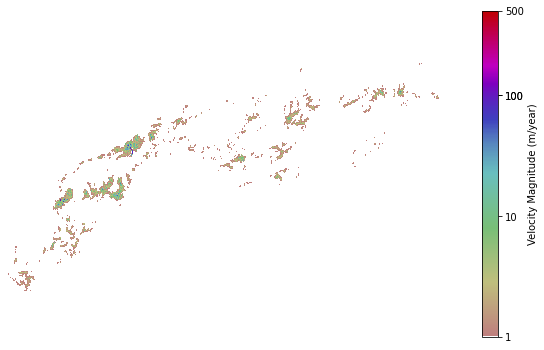

In [13]:
plt.figure(figsize=(10,12))
fig = plt.imshow(scaled_ds, origin='lower', cmap=cmap)
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
tickval = [1, 10, 100, 100, 500]
t = np.log(tickval)
cb = plt.colorbar(fig, ticks=255*(t - t[0])/(t[-1] - t[0]), shrink=0.5)
cb.set_label('Velocity Magnitude (m/year)')
cb.ax.set_yticklabels(tickval)
plt.show()

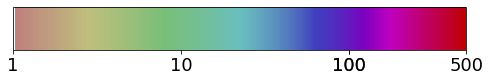

In [24]:
plt.figure(figsize=(9, 1.5))
img = plt.imshow(scaled_ds, cmap=cmap)
plt.gca().set_visible(False)
cax = plt.axes([0,0, 0.7, 0.4])
tickval = [1, 10, 100, 100, 500]
t = np.log(tickval)
cb = plt.colorbar(fig, ticks=255*(t - t[0])/(t[-1] - t[0]), shrink=0.5,cax=cax, orientation="horizontal")
cb.ax.set_xticklabels(tickval)
cb.ax.tick_params(labelsize=18)
plt.savefig("D:\\3_DataViz\\2_glaciers\\10_images\\colorbar_velocity.png")

In [32]:
# apply the colormap to the scaled data
rgb_ds = cmap(scaled_ds.data)
rgb_ds.shape
# Scale RGB values from [0,1] to [0,255]
data_array_scaled = np.interp(rgb_ds,(0, 1), (0, 255))
# Round to the nearest bigger integer
data_array_scaled = np.ceil(data_array_scaled)
data_array_scaled = data_array_scaled.astype(int)

print(data_array_scaled.shape)
print(data_array_scaled.min(), data_array_scaled.max())

(6182, 11722, 4)
0 255


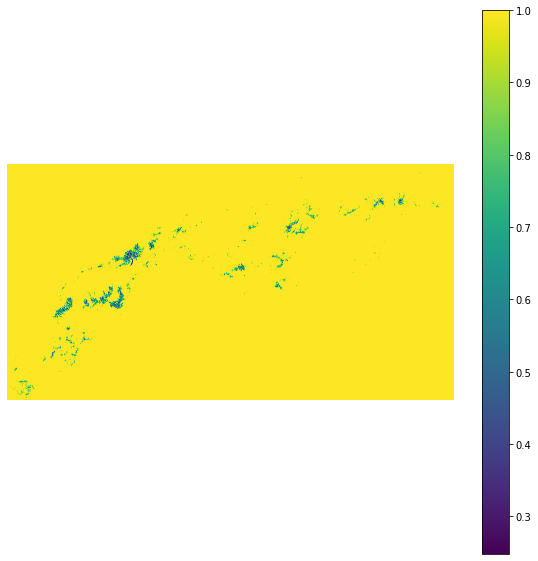

In [33]:
plt.figure(figsize=(10,10))
fig = plt.imshow(rgb_ds[:,:,0], origin='lower')
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
cb = plt.colorbar(fig)
plt.show()

# New Geotiff properties  

originX = top left coord - ```ds.thickness.coords['x'][0].data```

originY = top left coord - ```ds.thickness.coords['y'][0].data```

```pixelWidth = ds.thickness.coords['x'].data[1]- ds.thickness.coords['x'].data[0]```

```pixelHeight = ds.thickness.coords['y'].data[1]- ds.thickness.coords['y'].data[0]```


Number of bands = 3 (RGB) : ```bands = data_array_scaled.shape[2]-1```


Size in x direction: ```rows = ds.thickness.data.shape[1]```

Size in y direction: ```cols = ds.thickness.data.shape[0]```


In [34]:
print(ds.thickness.coords)
print(ds.thickness.data.shape)

Coordinates:
  * x        (x) int32 264325 264375 264425 264475 ... 850325 850375 850425
  * y        (y) int32 4963100 4963150 4963200 ... 5272100 5272150 5272200
(6182, 11722)


In [35]:
# Creates a copy of a 3-band raster with values from array'''
# GeoTIFF creation options : https://gdal.org/drivers/raster/gtiff.html

# Destination file name 
out_path = 'D:\\3_DataViz\\2_glaciers\\3_ncdf\\'
file_name = 'alps_velocity.tif'
dest_name = out_path + file_name

# info from source
originX = ds.thickness.coords['x'][0].data
originY = ds.thickness.coords['y'][0].data 
pixelWidth = ds.thickness.coords['x'].data[1]- ds.thickness.coords['x'].data[0]
pixelHeight = ds.thickness.coords['y'].data[1]- ds.thickness.coords['y'].data[0]
bands = data_array_scaled.shape[2]-1
rows = ds.thickness.data.shape[1]
cols = ds.thickness.data.shape[0]

# Get geotiff driver
driver = gdal.GetDriverByName('GTiff')
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF','COMPRESS=LZW','PREDICTOR=2','GDAL_TIFF_INTERNAL_MASK=YES']

# Create new raster
dest = driver.Create(dest_name,rows,cols, bands, eType=gdal.GDT_Byte,options=options)
dest.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

# Set metadata.SetGeoTransform(src.GetGeoTransform())
dest.GetRasterBand(1).WriteArray(np.around(data_array_scaled[:,:,0]))
dest.GetRasterBand(1).SetNoDataValue(255)
dest.GetRasterBand(2).WriteArray(np.around(data_array_scaled[:,:,1]))
dest.GetRasterBand(2).SetNoDataValue(255)
dest.GetRasterBand(3).WriteArray(np.around(data_array_scaled[:,:,2]))
dest.GetRasterBand(3).SetNoDataValue(255)

#Set the projection of the GeoTiff [same as source] ( 

destSRS = osr.SpatialReference()
destSRS.ImportFromProj4 (ds.proj4)
dest.SetProjection(destSRS.ExportToWkt())

# Close datasets
#src = None
dest = None


In [44]:
# 1. add an alpha band to the RGB for transparent background in Mapbox
# 2. reprojection in web mercator (3857)
src_file = out_path + file_name
out_file = file_name.replace('.tif','_rgba_3857.tif')
dest_file = out_path + out_file

options = gdal.WarpOptions(format='GTiff', srcNodata=255, dstSRS='EPSG:3857', dstAlpha=True)
dest = gdal.Warp(dest_file, src_file, options=options)
print("Processing done for "+ out_file)
dest = None

#3. creation du MBTiles

mb_file = file_name.replace('.tif','.mbtiles')

# Create the mbtiles files
creation_opt = ["TILE_FORMAT=PNG8","ZLEVEL=9"]
options = gdal.TranslateOptions(format = 'mbtiles')
gdal.Translate(destName=out_path+mb_file ,srcDS=dest_file, options = options,creationOptions= creation_opt)

# Create the Zoom level [equivalent to gdaladdo with CLI]
Image = gdal.Open(mb_file, 1)  # 0 = read-only, 1 = read-write.
gdal.SetConfigOption('COMPRESS_OVERVIEW', 'LZW')
Image.BuildOverviews('CUBIC', [2, 4, 8, 16, 32], gdal.TermProgress_nocb)
del Image  # close the dataset (Python object and pointers)
print("Tiles produced for "+ mb_file)

Processing done for alps_velocity_rgba_3857.tif
Tiles produced for alps_velocity.mbtiles


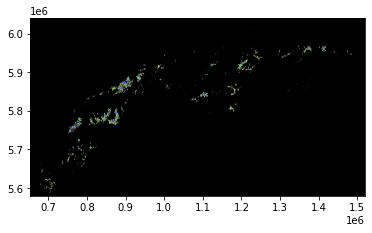

<AxesSubplot:>

In [37]:
fp = dest_file
img = rasterio.open(fp)
show(img)